In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 1000, threshold = 10000)

In [ ]:
# Grid parameters.
nh_min = 64
refRatio = 2
cfInter = int((nh_min / refRatio) + 3)

# Time integration parameters.
CFL = np.sqrt(0.5)
nt = 100
deriv = 'CD'
RK = 4
order = 2

# Waveform parameters.
x_0 = 0.
x_1 = float(cfInter) / float(nh_min)

# Physical parameters.
L = 1e-3
locs = []#x_1]
epsilons_r = [1]#, 11.68]
mus_r = [1]#, 0.99837]

# Pseudo-FFT parameters.
Hans = False

In [ ]:
omega = BT.Grid(nh)
finehalf = list(np.arange(cfInter))# + int(nh / refRatio))

In [2]:
def MakeRotMat(omega, ct):
    nh = omega.nh_max
    Cosine = lambda k: np.cos(2. * np.pi * k * ct)
    Sine = lambda k: np.sin(2. * np.pi * k * ct)
    RotMat = lambda k: np.asarray([k, k, -k, k]).reshape(2, 2)
    rotMats = [RotMat(k) for k in range(int(nh / 2) + 1)]
    shift = LA2.block_diag(*rotMats)[1:-1, 1:-1]
    shift[0, 0] = 0
    shift[::-1, ::-1][0, 0] = int(nh / 2)
    return shift

In [4]:
def Func1(omega, arg1, arg2, arg3):
    print('Func1:', arg1, arg2, arg3)
    return

In [5]:
def Func2(omega, arg1, arg2):
    print('Func2:', arg1, arg2)
    return

In [6]:
def TestFunc(omega, args, *Funcs):
    i = 0
    for Func in Funcs:
        Func(omega, *args[i])
        i = i + 1
    return

In [4]:
def funk(x):
    return -x

def outer_func(func, x): #(switch statement, )
    y = 4
    def inner_func(z):
        print(f"x = {x}, y = {y}, z = {z}")
        return func(x + y + z) + 0.5
    return inner_func

for i in range(3):
    closure = outer_func(funk, i)
    print(f"closure({i+5}) = {closure(i+5)}")

x = 0, y = 4, z = 5
closure(5) = -8.5
x = 1, y = 4, z = 6
closure(6) = -10.5
x = 2, y = 4, z = 7
closure(7) = -12.5


In [7]:
args1 = '1A', '1B', '1C'
args2 = '2A', '2B'
args = [[*args1], [*args2]]

TestFunc(omega, args, Func1, Func2)

Func1: 1A 1B 1C
Func2: 2A 2B


In [8]:
print(args1)
print(*args1)
print(args)
print(args[0])
print(*args[0])

('1A', '1B', '1C')
1A 1B 1C
[['1A', '1B', '1C'], ['2A', '2B']]
['1A', '1B', '1C']
1A 1B 1C


In [9]:
# ----------------------------------------------------------------------------------------------------------------
# Function: Block
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function creates either a block diagonal or block anti-diagonal matrix from some operator or list of
# operators. If the input matrica is a single operator, then a matrix of var many blocks of that operator is
# constructed. If matrica is input directly as a list of operators, then a block diagonal of all the operators
# within that list is constructed. If the parameter diag is set to False, then the output is changed to a block
# antidiagonal matrix.
# ----------------------------------------------------------------------------------------------------------------
# Inputs:
#
# matrica                 array/list              Operator or list of operators to be reconstructed in blocks
# (var)                   int                     Number of blocks if matrica entered as array
# (diag)                  boolean                 Switch paramater for diagonal or antidiagonal blocks
# ----------------------------------------------------------------------------------------------------------------
# Outputs:
#
# matrice                 array                   Block diagonal or antidiagonal matrix
# ----------------------------------------------------------------------------------------------------------------

def Block(matrica, var = 1, diag = True):
    errorLoc = 'ERROR:\nOperatorTools:\nBlock:\n'
    if ((var < 1) or (type(var) != int)):
        errorMess = 'var must be integer value greater than 0!'
    if (type(matrica) == list):
        var = np.shape(matrica)[0]
        matricaList = matrica
    else:
        matricaList = [matrica for k in range(var)]
    if (not diag):
        matricaList = [M[:, ::-1] for M in matricaList]
    matrice = LA2.block_diag(*matricaList)
    if (not diag):
        matrice = matrice[:, ::-1]
    return matrice

In [10]:
A = np.arange(20).reshape(4, 5)
# A = A[:, ::-1]
B = -np.arange(20).reshape(4, 5)
AA = [A for k in range(2)]
AB = [A, B]
print(A)
print(AA)
print(AB)
print(type(A))
print(type(AA))
print(type(AB))
print(np.shape(A))
print(np.shape(AA))
print(np.shape(AB)[0])
print('')

BlockA = Block(A, var = 2)
BlockAA = Block(AA)
BlockAB = Block(AB)
print(BlockA)
print(BlockAA)
print(BlockAB)
print('')
BlockA1 = Block(A, var = 2, diag = False)
BlockAA1 = Block(AA, diag = False)
BlockAB1 = Block(AB, diag = False)
print(BlockA1)
print(BlockAA1)
print(BlockAB1)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
[array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]]), array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])]
[array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]]), array([[  0,  -1,  -2,  -3,  -4],
       [ -5,  -6,  -7,  -8,  -9],
       [-10, -11, -12, -13, -14],
       [-15, -16, -17, -18, -19]])]
<class 'numpy.ndarray'>
<class 'list'>
<class 'list'>
(4, 5)
(2, 4, 5)
2

[[ 0  1  2  3  4  0  0  0  0  0]
 [ 5  6  7  8  9  0  0  0  0  0]
 [10 11 12 13 14  0  0  0  0  0]
 [15 16 17 18 19  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  2  3  4]
 [ 0  0  0  0  0  5  6  7  8  9]
 [ 0  0  0  0  0 10 11 12 13 14]
 [ 0  0  0  0  0 15 16 17 18 19]]
[[ 0  1  2  3  4  0  0  0  0  0]
 [ 5  6  7  8  9  0  0  0  0  0]
 [10 11 12 13 14  0  0  0  0

In [11]:
A = np.arange(20)
B = np.arange(20)
#AB = PT.Load(A, B)
AB = np.asarray(list(np.append(A, B)))
print(AB)
print(AB[:8])
for k in range(4):
    print(AB[k*5:(k + 1) * 5])
    print('')
    

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[0 1 2 3 4 5 6 7]
[0 1 2 3 4]

[5 6 7 8 9]

[10 11 12 13 14]

[15 16 17 18 19]



In [12]:
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)
print(t)

0.0625


In [13]:
waves = WT.MakeWaves(omega)


[2 3 4 5]


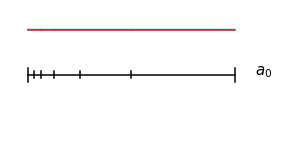

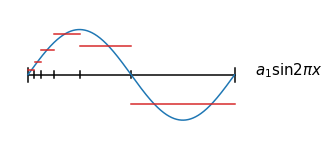

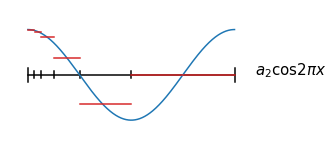

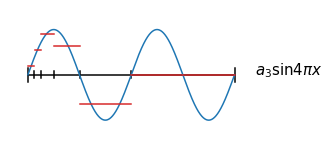

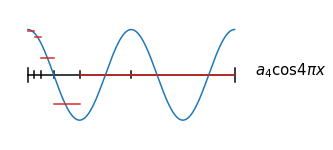

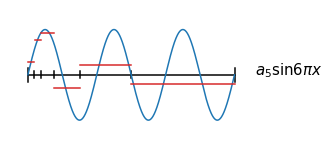

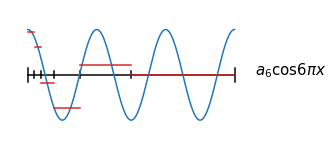

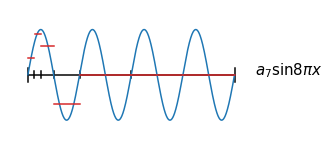

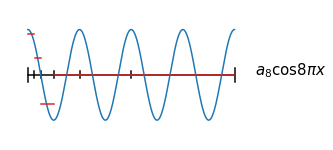

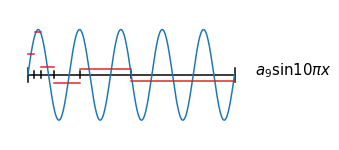

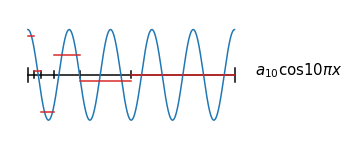

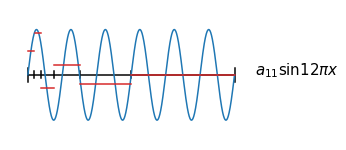

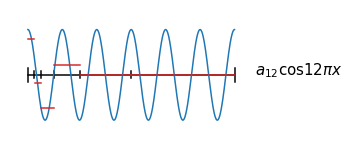

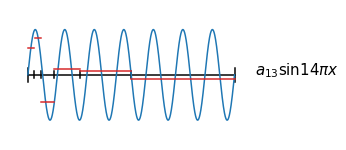

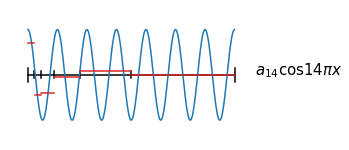

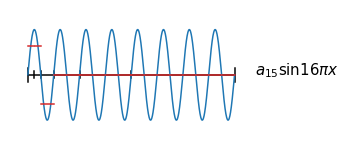

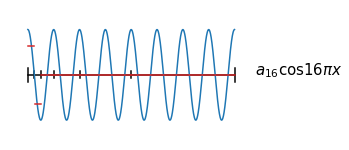

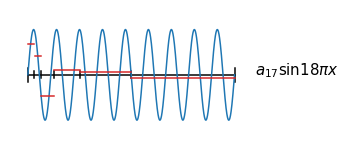

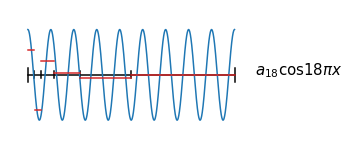

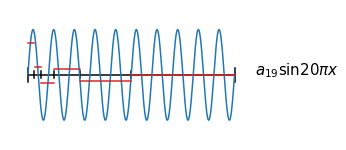

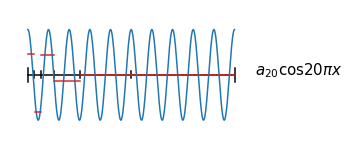

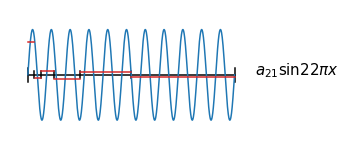

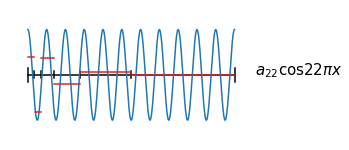

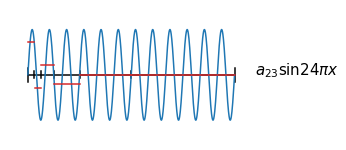

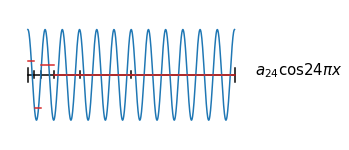

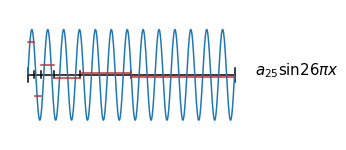

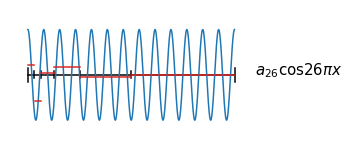

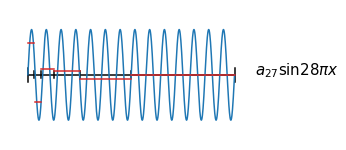

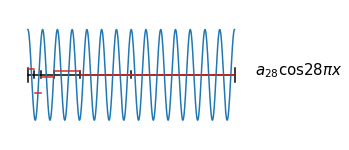

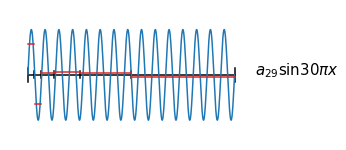

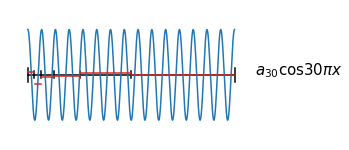

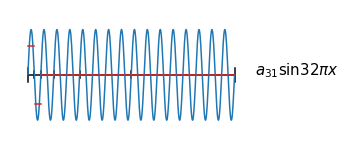

In [14]:
print(np.arange(2, 6))
PT.PlotWaves(omega, waves = waves)

In [15]:
 def PropWaves(omega, waves, c, t):
    nh2 = omega.nh_max
    nhs = omega.nh
    hs = omega.h
    levels = omega.levels
    refRatios = omega.refRatios
    rotMat = MakeRotMat(omega, c * t)
    backRotMat = rotMat[::-1, ::-1] + 0
    np.fill_diagonal(backRotMat[1:], np.diagonal(backRotMat, offset = 1))
    np.fill_diagonal(backRotMat[:, 1:], -np.diagonal(backRotMat, offset = 1))
    compRotMat = rotMat + 0
    compRotMat[::-1, ::-1][0, 0] = 0
    print(rotMat)
    h = 1. / nh2
    # aliasedWaves = int(nhs[0])
    fineSpots = np.where(hs == h)[0]
    wavesAlias = waves + 0
    # wavesAlias[:, :aliasedWaves] = 0
    wavesAlias[fineSpots, :] = 0
    workingWaves = waves - wavesAlias
    propMat = workingWaves @ rotMat
    print('nh =', nh2)
    print(workingWaves)
    refRatioTot = 1
    for q in range(levels):
        nh0 = nhs[::-1][q + 1]
        if (q == 0):
            nh1 = nh0
        refRatio = refRatios[::-1][q]
        refRatioTot = refRatioTot * refRatio
        print('nh = ', nh0)
        h = 1. / nh0
        for p in range(refRatioTot - 1):
            s0 = 2 * (p % 2)
            startPoint = nh0 * (p + 1) - s0
            endPoint = startPoint + nh0 + s0
            compRotMat[startPoint + 1:endPoint - 1, startPoint + 1:endPoint - 1] = backRotMat[nh2 - nh0 - s0 + 1:nh2 - 1, nh2 - nh0 - s0 + 1:nh2 - 1]
        workingWaves = wavesAlias + 0
        fineSpots = np.where(hs != h)[0]
        workingWaves[fineSpots, :] = 0
        propMat = propMat + (workingWaves @ backRotMat)
        wavesAlias = wavesAlias - workingWaves
        print(compRotMat)
        print('workingWaves')
        print(workingWaves)
    print('\nSTOP!\n')
    return propMat
blah = PropWaves(omega, waves, c, t)
propWaves = FFTT.PropWaves(omega, waves, c, t)
nullspace = OT.FindNullspace(omega, propWaves, shift = True)


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  -1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   2   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  -2   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   3   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  -3   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   4   4   0   0   0   0   0   0   0   0   0   0   0  

TypeError: PropWaves() takes 3 positional arguments but 4 were given

In [ ]:
# print(np.where(nullspace != 0)[1])
PT.PlotWaves(omega, waves = propWaves, ct = c * t)

In [ ]:
PT.PlotWaves(omega, waves = propWaves, nullspace = nullspace, ct = c * t)

In [ ]:
A = MakeRotMat(omega)
B = A[::-1, ::-1] + 0 # np.roll(A, 1, axis = 0)
np.fill_diagonal(B[1:], np.diagonal(B, offset = 1))
np.fill_diagonal(B[:, 1:], -np.diagonal(B, offset = 1))
C = np.roll(B, 7, axis = 0)
C = np.roll(C, 7, axis = 1)

In [ ]:
print('A =\n', A)
print('')
print('B =\n', B)
print('')
print('C =\n', C)
print('')